In [32]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np


print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.2


In [33]:
train_df = pd.read_csv(os.path.join(os.getcwd(),'data','train.csv'))
columns_to_train = ['Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'FGC-FGC_CU', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'sii']

# Let's keep only the values that contain 'sii' values
train_df = train_df.loc[:,columns_to_train]
train_df = train_df[train_df['sii'].isna() == False]
val_df = train_df.sample(frac=0.1, random_state=42)
train_df = train_df.drop(val_df.index)

train_df.shape, val_df.shape

((2462, 8), (274, 8))

In [34]:
from sklearn.impute import KNNImputer

def input_missing_data(df:pd.DataFrame):
    df = df.copy()    
    imputer_5n=KNNImputer(n_neighbors=5)
    imputer_10n=KNNImputer(n_neighbors=10)
    imputer_50n=KNNImputer(n_neighbors=50)
    imputer_100n=KNNImputer(n_neighbors=100)
    knn_imputed=(imputer_5n.fit_transform(df) + imputer_10n.fit_transform(df) + imputer_50n.fit_transform(df) + imputer_100n.fit_transform(df)) / 4
    knn_imputed_df=pd.DataFrame(knn_imputed,columns=imputer_50n.get_feature_names_out())
    knn_imputed_df['sii'] = np.round(knn_imputed_df['sii'])
    return knn_imputed_df


train_df = input_missing_data(train_df)
val_df = input_missing_data(val_df)

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462 entries, 0 to 2461
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         2462 non-null   float64
 1   Physical-BMI                            2462 non-null   float64
 2   Physical-Height                         2462 non-null   float64
 3   Physical-Weight                         2462 non-null   float64
 4   FGC-FGC_CU                              2462 non-null   float64
 5   SDS-SDS_Total_T                         2462 non-null   float64
 6   PreInt_EduHx-computerinternet_hoursday  2462 non-null   float64
 7   sii                                     2462 non-null   float64
dtypes: float64(8)
memory usage: 154.0 KB


In [36]:
def dataframe_to_dataset(df:pd.DataFrame):
    df = df.copy()
    labels = df.pop('sii')
    labels = labels.astype(np.uint8)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    return ds

train_ds = dataframe_to_dataset(train_df)
train_ds = train_ds.batch(32)

val_ds = dataframe_to_dataset(val_df)
val_ds = val_ds.batch(32)

In [37]:
for x,y in train_ds.take(1):
    print("Input:", x)
    print("Label:", y)

Input: {'Basic_Demos-Age': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([17., 20.,  6., 10.,  6., 16., 15.,  9., 12.,  7., 10., 10.,  6.,
        9.,  9.,  8.,  9., 12., 11.,  8.,  6., 13.,  8., 11., 10., 16.,
       12.,  7., 12., 12.,  9.,  8.])>, 'Physical-BMI': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([23.15264288, 31.62872446, 16.19514463, 16.3103806 , 15.76589474,
       17.28717561, 18.97833117, 23.90472182, 22.06675625, 16.23907765,
       17.82381518, 15.0436214 , 15.55242121, 17.46863653, 24.28348348,
       19.05191584, 14.28591682, 18.81778384, 17.52956047, 22.95510204,
       20.53753673, 20.71705837, 14.66316568, 18.5452562 , 15.97372222,
       23.01031541, 27.20604686, 15.6914318 , 19.78787721, 17.59328824,
       15.52261333, 19.62421125])>, 'Physical-Height': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([66.9   , 71.    , 44.    , 58.5   , 47.5   , 63.    , 63.25  ,
       54.5   , 61.    , 49.5   , 54.75  , 54.    , 45.5   , 53.    ,
     

2024-10-27 20:56:22.544531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
def encode_numerical_features(feature, name, dataset):
    # Create a Normalization layer for our numerical feature
    normalizer = tf.keras.layers.Normalization()
    
    # We get the feature from our dataset
    feature_ds = dataset.map(lambda x,_: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x,-1))
    
    normalizer.adapt(feature_ds)
    
    encoded_feature = normalizer(feature)
    return encoded_feature

In [39]:
# Numerical features
age = tf.keras.Input(shape=(1,),name="Basic_Demos-Age")
bmi = tf.keras.Input(shape=(1,),name="Physical-BMI")
height = tf.keras.Input(shape=(1,),name="Physical-Height")
weight = tf.keras.Input(shape=(1,),name="Physical-Weight")
fgc = tf.keras.Input(shape=(1,),name="FGC-FGC_CU")
sds = tf.keras.Input(shape=(1,),name="SDS-SDS_Total_T")
internet = tf.keras.Input(shape=(1,),name="PreInt_EduHx-computerinternet_hoursday")


age_encoded = encode_numerical_features(age, "Basic_Demos-Age", train_ds)
bmi_encoded = encode_numerical_features(bmi, "Physical-BMI", train_ds)
height_encoded = encode_numerical_features(height, "Physical-Height", train_ds)
weight_encoded = encode_numerical_features(weight, "Physical-Weight", train_ds)
fgc_encoded = encode_numerical_features(fgc, "FGC-FGC_CU", train_ds)
sds_encoded = encode_numerical_features(sds, "SDS-SDS_Total_T", train_ds)
internet_encoded = encode_numerical_features(internet, "PreInt_EduHx-computerinternet_hoursday", train_ds)

all_inputs = [age,bmi,height,weight,fgc,sds,internet]

all_features = tf.keras.layers.concatenate([
	age_encoded,
	bmi_encoded,
	height_encoded,
	weight_encoded,
	fgc_encoded,
	sds_encoded,
	internet_encoded
])


x = tf.keras.layers.Dense(32, activation='relu')(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(all_inputs, output)
model.compile("adam","crossentropy",metrics=["accuracy"])
model.summary()

2024-10-27 20:56:22.785861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 20:56:22.955214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 20:56:23.136605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 20:56:23.311369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 20:56:23.489558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 20:56:23.668348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 20:56:23.838195: W tensorflow/core/framework/local_rendezvous.cc:404] L

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Basic_Demos-Age     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Physical-BMI        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Physical-Height     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Physical-Weight     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FGC-FGC_CU          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SDS-SDS_Total_T     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PreInt_EduHx-compu… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_14    │ (None, 1)         │          3 │ Basic_Demos-Age[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_15    │ (None, 1)         │          3 │ Physical-BMI[0][… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_16    │ (None, 1)         │          3 │ Physical-Height[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_17    │ (None, 1)         │          3 │ Physical-Weight[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_18    │ (None, 1)         │          3 │ FGC-FGC_CU[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_19    │ (None, 1)         │          3 │ SDS-SDS_Total_T[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_20    │ (None, 1)         │          3 │ PreInt_EduHx-com… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 7)         │          0 │ normalization_14… │
│ (Concatenate)       │                   │            │ normalization_15… │
│                     │                   │            │ normalization_16… │
│                     │                   │            │ normalization_17… │
│                     │                   │            │ normalization_18… │
│                     │                   │            │ normalization_19… │
│                     │                   │            │ normalization_20

 Total params: 409 (1.62 KB)

 Trainable params: 388 (1.52 KB)

 Non-trainable params: 21 (112.00 B)

In [40]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds, verbose=0)

/Users/lucaswerner/Desktop/projects/kaggle/child_mind_institute/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'FGC-FGC_CU', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday']. Received: the structure of inputs={'Basic_Demos-Age': '*', 'Physical-BMI': '*', 'Physical-Height': '*', 'Physical-Weight': '*', 'FGC-FGC_CU': '*', 'SDS-SDS_Total_T': '*', 'PreInt_EduHx-computerinternet_hoursday': '*'}
  warnings.warn(


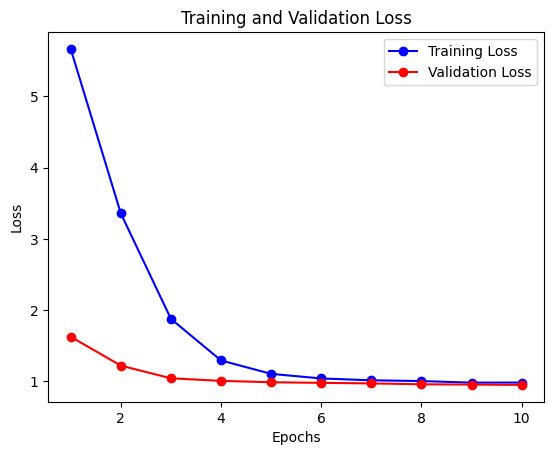

In [41]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
import collections
predictions = np.argmax(model.predict(val_ds), axis=1)
counter = collections.Counter(predictions)
counter

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Counter({0: 259, 2: 8, 1: 7})

In [43]:
# Try with a more complex model
x = tf.keras.layers.Dense(256, activation='relu')(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(all_inputs, output)
model.compile("adam","crossentropy",metrics=["accuracy"])


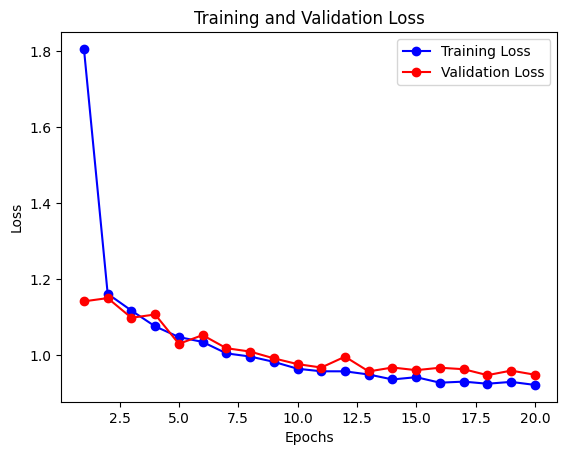

In [44]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds, verbose=0)

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
predictions = np.argmax(model.predict(val_ds), axis=1)
counter = collections.Counter(predictions)
counter

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Counter({0: 262, 1: 12})

In [46]:
val_targets = val_ds.unbatch().map(lambda x,y: y)
val_targets = list(val_targets.as_numpy_iterator())
for target, prediction in zip(val_targets,predictions):
    if target != prediction:
        print("Target: ", target, " Prediction:", prediction)

Target:  1  Prediction: 0
Target:  2  Prediction: 0
Target:  2  Prediction: 0
Target:  1  Prediction: 0
Target:  2  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  2  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  2  Prediction: 0
Target:  1  Prediction: 0
Target:  3  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  2  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  2  Prediction: 0
Target:  3  Prediction: 0
Target:  1  Prediction: 0
Target:  2  Prediction: 0
Target:  2  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  0  Prediction: 1
Target:  2  Prediction: 1
Target:  2  Prediction: 1
Target:  2  Prediction: 0
Target:  1  Prediction: 0
Target:  1  Prediction: 0
Target:  1  

2024-10-27 20:56:33.783047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
